In [126]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
parent_directory = str(Path().resolve().parent)
parent_directory

import os,sys 
script_path = os.path.abspath("../src")  # Adjust the path
sys.path.append(script_path)
print(parent_directory)

/Users/yiminglin/Documents/Codebase/doc-provenance


In [195]:
import json 
import tiktoken

def read_json(path):
    if not os.path.exists(path):
        print('File not found!', path)
        return None
    with open(path, "r", encoding="utf-8") as file:
        data = json.load(file)
    return data

def count_tokens(text, model="gpt-4o-mini"):
    encoder = tiktoken.encoding_for_model(model)  # Get the tokenizer for the specific model
    tokens = encoder.encode(text)  # Encode text into tokens
    return len(tokens)

def write_json_to_file(filename, data):
    with open(filename, "w") as f:
        json.dump(data, f, indent=4)

import statistics

def find_substantially_large(values, factor=2):
    """
    Find and return the values in the list that are substantially larger than the average.
    
    A value is considered substantially large if it is greater than:
        mean + (factor * standard deviation)
    
    Parameters:
        values (list of numbers): The list of values to analyze.
        factor (float): The number of standard deviations above the mean 
                        that a value must be to be considered substantially large.
                        Default is 2.
    
    Returns:
        list: A list of values that exceed the threshold.
    """
    if not values:
        return [], 0 
    
    mean = statistics.mean(values)
    stdev = statistics.stdev(values)
    threshold = mean + factor * stdev
    return [v for v in values if v > threshold], mean



In [215]:
def get_results(data_path, result_folder_path, sufficient_provenance_strategy, minimal_provenance_strategy, dataset):
    objects = read_json(data_path)
    results = {}
    strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
    i = 0
    num_case = 500
    time_list = []
    cost_list = []
    for o in objects:
        i += 1
        if dataset == 'hotpotQA':
            title = o['document_name']
        else:
            title = o['id']
        result_path = result_folder_path + str(i) + '_' + str(title) + '_'  + strategy + '.json'
        if not os.path.exists(result_path):
            # if i < num_case:
            #     print('path not exist:', result_path)
            continue
        result = read_json(result_path)
        if 'tokens' not in result:
            # if i < num_case:
            #     print('result not exist:', result_path)
            continue
        r = {}
        #print(i, strategy)
        r['document_size'] = result['document_size']
        r['provenance_size'] = result['provenance_size']
        r['time'] = result['time']
        r['tokens'] = result['tokens']
        time_list.append(r['time'])
        cost_list.append(r['tokens'][0] + r['tokens'][1])
        results[i] = r

    #print('time, cost size:', len(time_list), len(cost_list))
    time_large_vals, time_mean = find_substantially_large(time_list)
    cost_large_vals, cost_mean = find_substantially_large(cost_list) 

    # print('time stats:', time_large_vals, time_mean)
    # print('cost stats:', cost_large_vals, cost_mean)
    updated_results = {}
    for rid, result in results.items():
        time = result['time']
        cost = result['tokens'][0] + result['tokens'][1]
        if time in time_large_vals:
            continue
        if cost in cost_large_vals:
            continue
        updated_results[rid] = result 

    return updated_results        

def get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path, dataset): 

    size_ratios = {}
    large_case_ids = {}
    medium_case_ids = {}
    provenance_size_dict = {}
    size_ratio_dict = {}
    time_dict = {}
    cost_dict = {}
    document_size_dict = {}
    time_distribution = {}
    cost_distribution = {}

    for sufficient_provenance_strategy in sufficient_provenance_strategy_pool:
        for minimal_provenance_strategy in minimal_provenance_strategy_pool:
            strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
            # if minimal_provenance_strategy != 'null':
            #     continue
            print(strategy)
            results = get_results(data_path, result_folder_path, sufficient_provenance_strategy, minimal_provenance_strategy, dataset)
            #print(len(results))
            avg_provenance_size = 0
            avg_size_ratio = 0
            avg_time = 0
            avg_in_tokens = 0
            avg_out_tokens = 0
            avg_document_size = 0

            size_ratio_list = []
            large_case_id = []
            medium_case_id = []
            time_list = []
            cost_list = []
            cnt = 0
            for rid, result in results.items():
                size_ratio = result['provenance_size']/result['document_size']
                provenance_size = result['provenance_size']
                time = result['time']
                in_tokens = result['tokens'][0]
                out_tokens = result['tokens'][1] 
                document_size = result['document_size']

                avg_provenance_size += provenance_size
                avg_size_ratio += size_ratio
                avg_time += time 
                avg_in_tokens += in_tokens
                avg_out_tokens += out_tokens
                avg_document_size += document_size
                cnt += 1


                size_ratio_list.append(size_ratio)
                time_list.append(time)
                cost_list.append(in_tokens + out_tokens)

            avg_provenance_size /= cnt
            avg_size_ratio /= cnt
            avg_time /= cnt
            avg_in_tokens /= cnt
            avg_out_tokens /= cnt
            avg_document_size /= cnt
            print('provenance_size, size_ratio:', avg_provenance_size, avg_size_ratio)
            print('time:', avg_time)
            print('tokens:', avg_in_tokens, avg_out_tokens)
            print('')
            size_ratios[strategy] = size_ratio_list
            time_distribution[strategy] = time_list
            cost_distribution[strategy] = cost_list 
            large_case_ids[strategy] = large_case_id
            medium_case_ids[strategy] = medium_case_id

            provenance_size_dict[strategy] = avg_provenance_size
            size_ratio_dict[strategy] = avg_size_ratio
            time_dict[strategy] = avg_time
            cost_dict[strategy] = avg_in_tokens + avg_out_tokens
            document_size_dict[strategy] = avg_document_size

    return size_ratios, provenance_size_dict, size_ratio_dict, time_dict, cost_dict, document_size_dict, time_distribution, cost_distribution

def plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios):
    # Prepare your strategies
    plots = []
    titles = []

    for sufficient_provenance_strategy in sufficient_provenance_strategy_pool:
        for minimal_provenance_strategy in minimal_provenance_strategy_pool:
            # if minimal_provenance_strategy != 'null':
            #     continue
            strategy = sufficient_provenance_strategy + '_' + minimal_provenance_strategy
            print(strategy)
            a = size_ratios[strategy]
            plots.append(a)
            titles.append(strategy)

    # Set up subplots
    n = len(plots)
    cols = 3  # adjust columns as needed
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    for i, (a, title) in enumerate(zip(plots, titles)):
        counts, bins, _ = axes[i].hist(a, bins='auto', edgecolor='black')
        total = counts.sum()
        percentages = (counts / total) * 100

        # Clear and re-plot using percentages
        axes[i].cla()
        axes[i].bar(bins[:-1], percentages, width=np.diff(bins), align='edge', edgecolor='black')
        axes[i].set_title(f'{title}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency (Percentage)')
        axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))

    # Hide any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_table(provenance_size_dict, size_ratio_dict, time_dict, cost_dict):
        format_dict = lambda d: {k: f"{v:.2f}" for k, v in d.items()}

        form_provenance_size_dict = format_dict(provenance_size_dict)
        form_size_ratio_dict = format_dict(size_ratio_dict)
        form_time_dict = format_dict(time_dict)
        form_cost_dict = format_dict(cost_dict)

        df = pd.DataFrame({'Provenance Size (Tokens)': form_provenance_size_dict, 'Provenance Size Ratio': form_size_ratio_dict, 'Latency': form_time_dict, 'Used Tokens': form_cost_dict})
        # Plot the table with larger size
        fig, ax = plt.subplots(figsize=(8, len(df)*0.6 + 1))  # Adjust height based on number of rows
        ax.axis('tight')
        ax.axis('off')

        table = ax.table(cellText=df.values,
                        rowLabels=df.index,
                        colLabels=df.columns,
                        cellLoc='center',
                        loc='center')

        # Increase font size
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.2)  # scale width, height

        try:
            table.auto_set_column_width(col=list(range(len(df.columns) + 1)))  # +1 for row labels
        except AttributeError:
            print("auto_set_column_width not available — upgrade matplotlib to >=3.4 for best effect.")


        plt.show()

In [197]:
#nl_dev  

dataset = 'nl_dev'
sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down','embedding_sufficient_top_down','embedding_sufficient_bottem_up', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['null','exponential_greedy','sequential_greedy']

data_path = parent_directory + '/data/natural-questions_nq-dev-full.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/nl_dev/results_minimal/'

size_ratios, provenance_size_dict, size_ratio_dict, time_dict, cost_dict, document_size_dict, time_distribution, cost_distribution = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path,dataset)


                

LLM_score_sufficient_bottem_up_null
provenance_size, size_ratio: 967.1205211726384 0.14779883320405557
time: 2.5396051298135265
tokens: 1621.2247557003257 22.697068403908794

LLM_score_sufficient_bottem_up_exponential_greedy
provenance_size, size_ratio: 242.0128617363344 0.055538467929432025
time: 13.380308711643771
tokens: 12784.855305466237 213.14790996784566

LLM_score_sufficient_bottem_up_sequential_greedy
provenance_size, size_ratio: 244.27124183006535 0.05707026763383907
time: 18.347290942092346
tokens: 21333.683006535946 306.0882352941176

LLM_score_sufficient_top_down_null
provenance_size, size_ratio: 1875.1672727272728 0.23741609601230595
time: 3.790302284414118
tokens: 6944.058181818182 38.64363636363636

LLM_score_sufficient_top_down_exponential_greedy
provenance_size, size_ratio: 337.73559322033896 0.07324777600203299
time: 22.354928028785576
tokens: 67450.15593220339 331.1186440677966

LLM_score_sufficient_top_down_sequential_greedy
provenance_size, size_ratio: 265.9713261

7814.330019604805


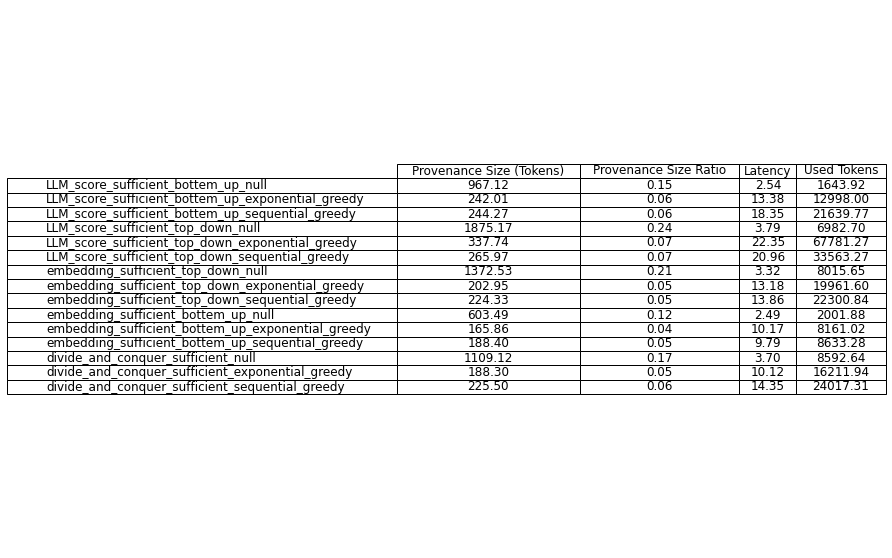

In [198]:
document_size = sum(document_size_dict.values()) / len(document_size_dict)
print(document_size)
plot_table(provenance_size_dict, size_ratio_dict, time_dict, cost_dict)

LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_bottem_up_exponential_greedy
LLM_score_sufficient_bottem_up_sequential_greedy
LLM_score_sufficient_top_down_null
LLM_score_sufficient_top_down_exponential_greedy
LLM_score_sufficient_top_down_sequential_greedy
embedding_sufficient_top_down_null
embedding_sufficient_top_down_exponential_greedy
embedding_sufficient_top_down_sequential_greedy
embedding_sufficient_bottem_up_null
embedding_sufficient_bottem_up_exponential_greedy
embedding_sufficient_bottem_up_sequential_greedy
divide_and_conquer_sufficient_null
divide_and_conquer_sufficient_exponential_greedy
divide_and_conquer_sufficient_sequential_greedy


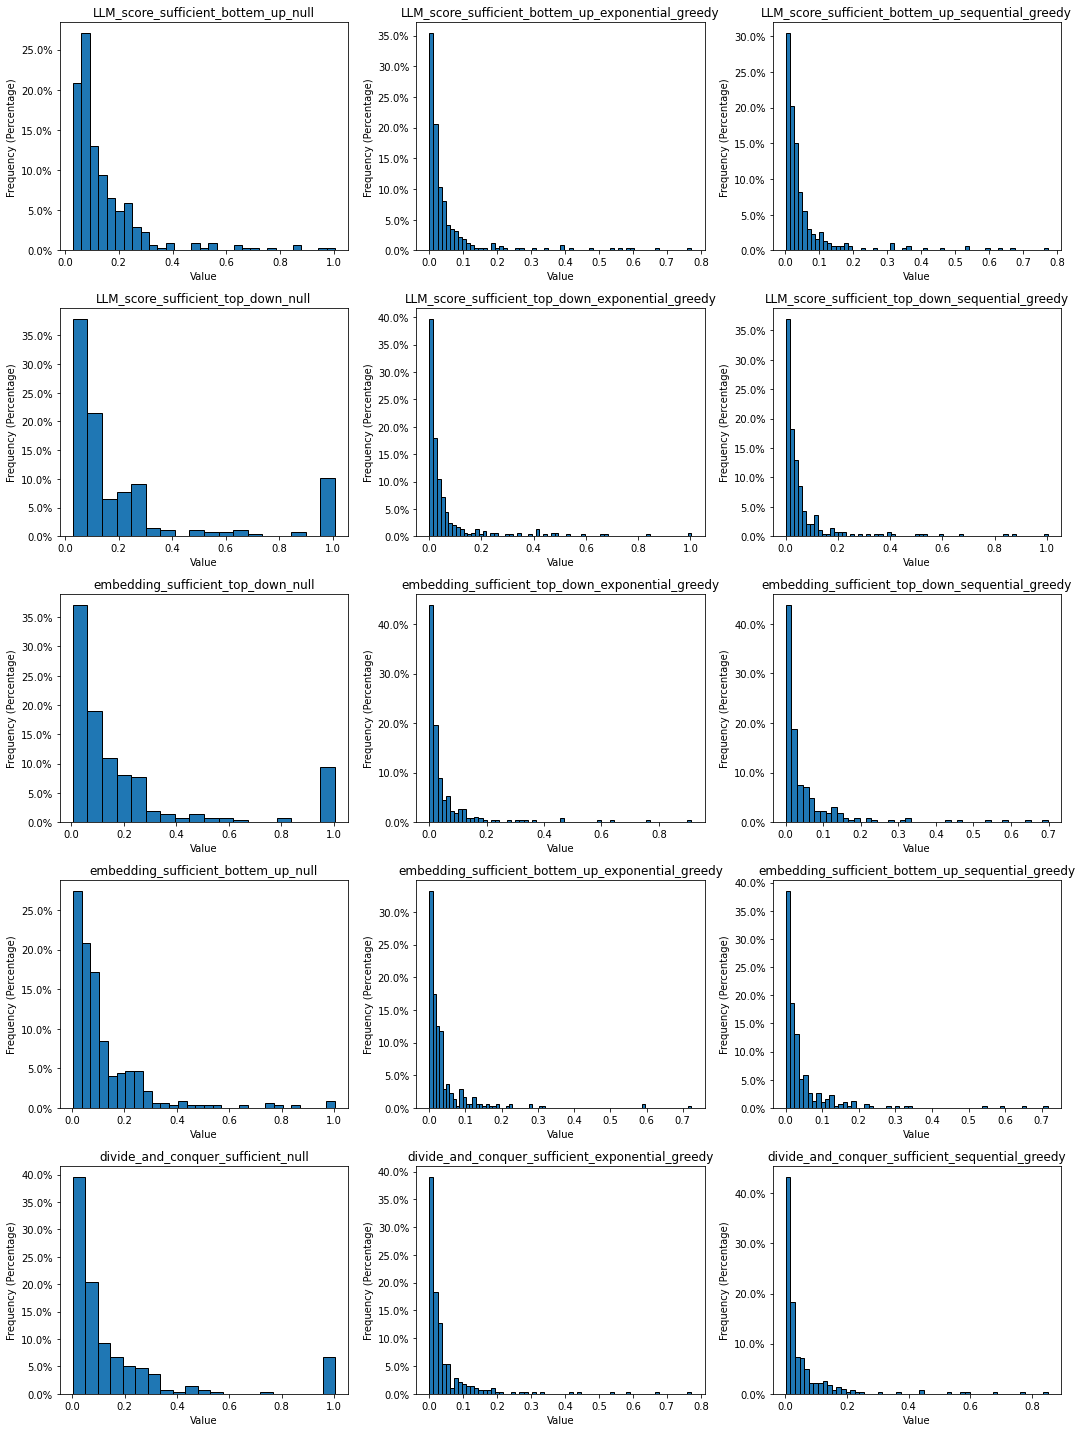

In [199]:

plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios)



LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_bottem_up_exponential_greedy
LLM_score_sufficient_bottem_up_sequential_greedy
LLM_score_sufficient_top_down_null
LLM_score_sufficient_top_down_exponential_greedy
LLM_score_sufficient_top_down_sequential_greedy
embedding_sufficient_top_down_null
embedding_sufficient_top_down_exponential_greedy
embedding_sufficient_top_down_sequential_greedy
embedding_sufficient_bottem_up_null
embedding_sufficient_bottem_up_exponential_greedy
embedding_sufficient_bottem_up_sequential_greedy
divide_and_conquer_sufficient_null
divide_and_conquer_sufficient_exponential_greedy
divide_and_conquer_sufficient_sequential_greedy


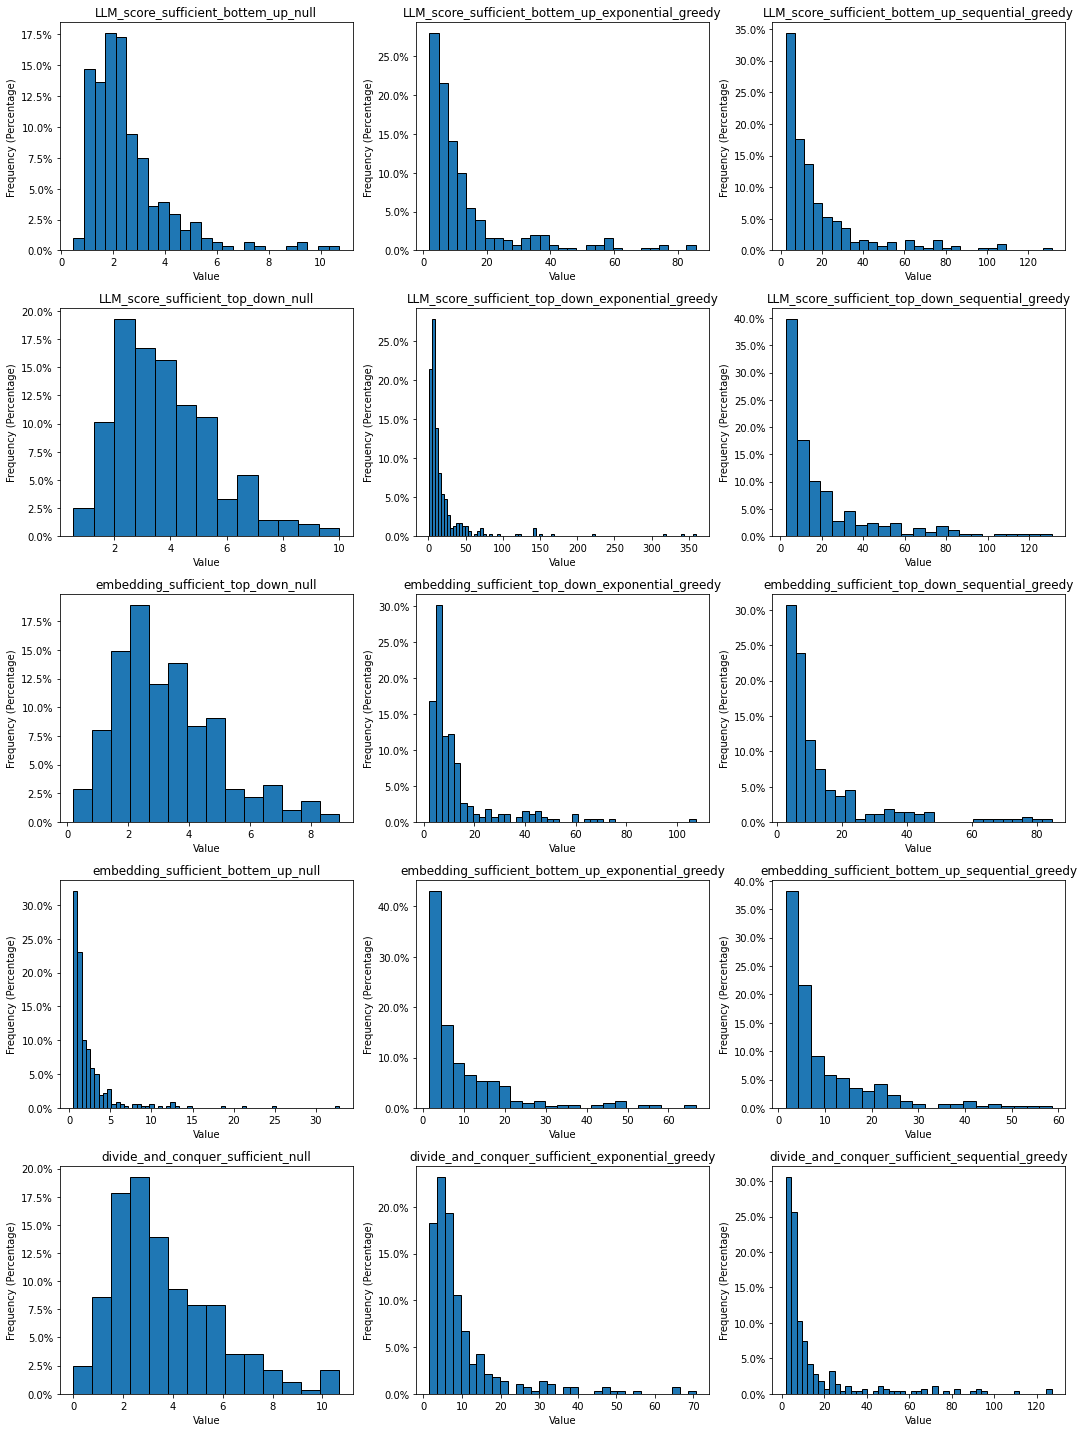

In [200]:

plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, time_distribution)

LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_bottem_up_exponential_greedy
LLM_score_sufficient_bottem_up_sequential_greedy
LLM_score_sufficient_top_down_null
LLM_score_sufficient_top_down_exponential_greedy
LLM_score_sufficient_top_down_sequential_greedy
embedding_sufficient_top_down_null
embedding_sufficient_top_down_exponential_greedy
embedding_sufficient_top_down_sequential_greedy
embedding_sufficient_bottem_up_null
embedding_sufficient_bottem_up_exponential_greedy
embedding_sufficient_bottem_up_sequential_greedy
divide_and_conquer_sufficient_null
divide_and_conquer_sufficient_exponential_greedy
divide_and_conquer_sufficient_sequential_greedy


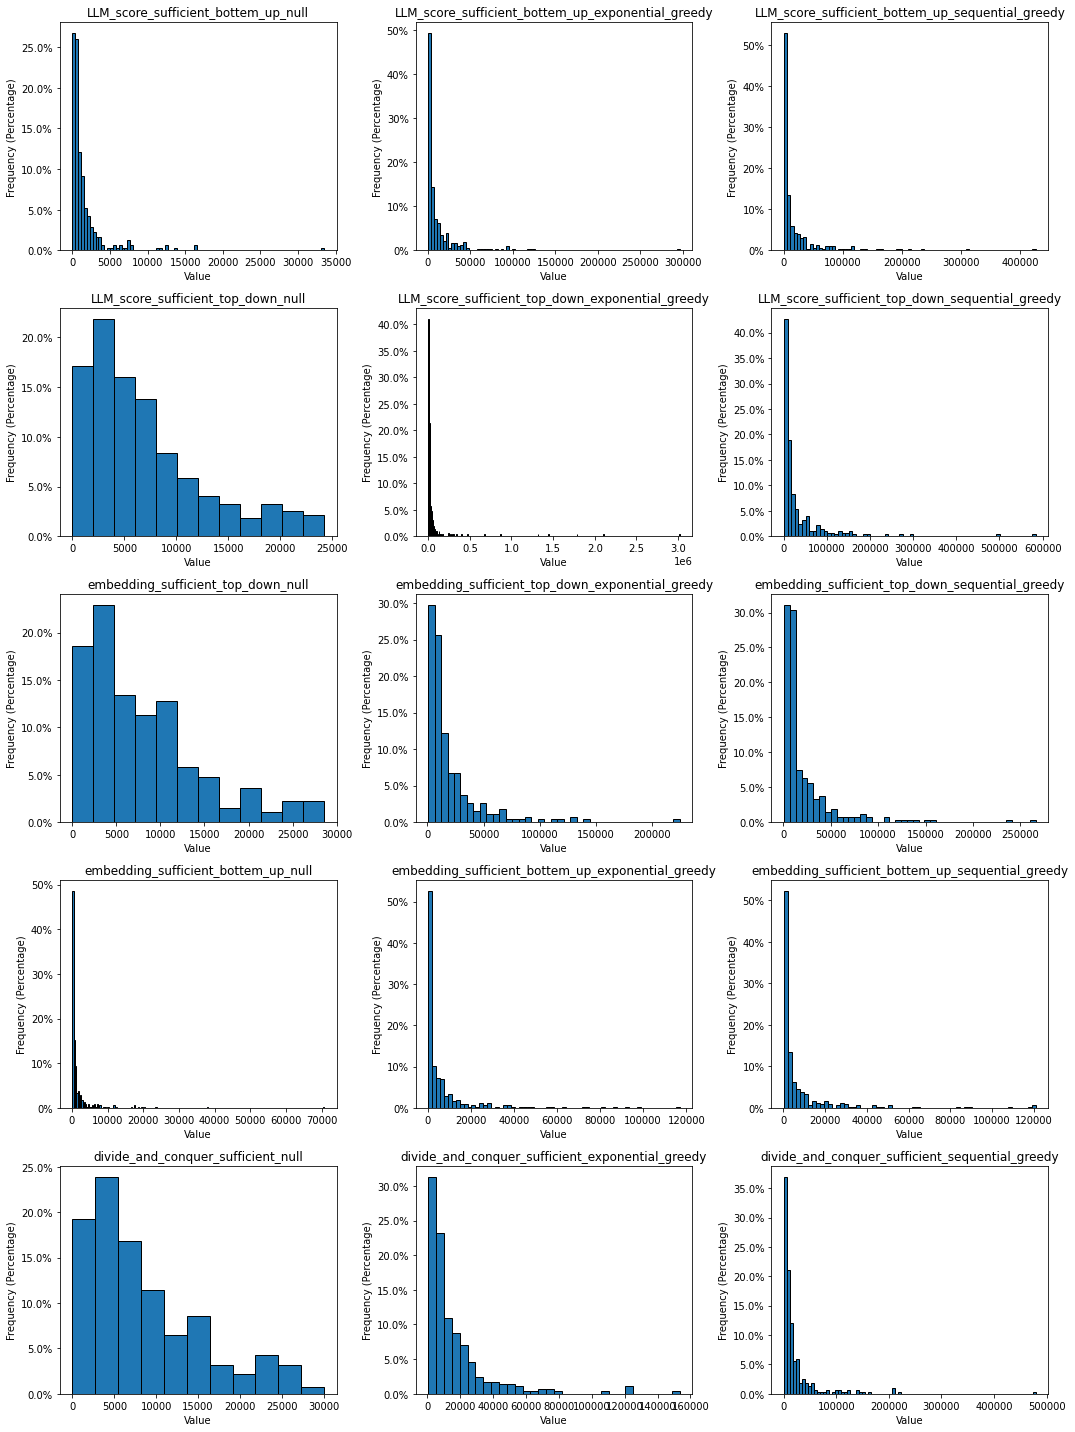

In [201]:
plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, cost_distribution)

In [203]:
#paper 

dataset = 'paper'
sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down','embedding_sufficient_top_down','embedding_sufficient_bottem_up', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['null','exponential_greedy','sequential_greedy']

data_path = parent_directory + '/data/qasper_sample_papers.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/paper/results_minimal/'

size_ratios, provenance_size_dict, size_ratio_dict, time_dict, cost_dict, document_size_dict, time_distribution, cost_distribution = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path,dataset)

    
                

LLM_score_sufficient_bottem_up_null
provenance_size, size_ratio: 519.7555555555556 0.1050967330844723
time: 2.7039953821235234
tokens: 1096.3138888888889 22.458333333333332

LLM_score_sufficient_bottem_up_exponential_greedy
provenance_size, size_ratio: 164.69973890339426 0.03836286040469883
time: 18.248700143151744
tokens: 15504.516971279374 299.69973890339423

LLM_score_sufficient_bottem_up_sequential_greedy
provenance_size, size_ratio: 141.4836956521739 0.03236416543346992
time: 15.403573899165444
tokens: 11230.491847826086 240.77173913043478

LLM_score_sufficient_top_down_null
provenance_size, size_ratio: 1008.9352750809062 0.19638298332818555
time: 3.7807594086360004
tokens: 4105.132686084143 39.07119741100323

LLM_score_sufficient_top_down_exponential_greedy
provenance_size, size_ratio: 135.15359477124184 0.03201665045453362
time: 15.601160357980167
tokens: 12493.898692810457 238.62418300653596

LLM_score_sufficient_top_down_sequential_greedy
provenance_size, size_ratio: 123.76450

5048.143760271458


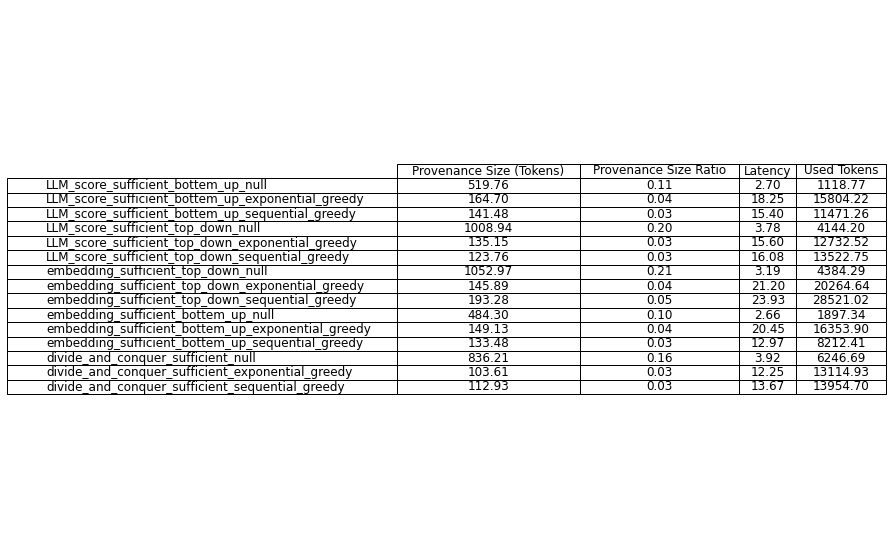

In [204]:
document_size = sum(document_size_dict.values()) / len(document_size_dict)
print(document_size)
plot_table(provenance_size_dict, size_ratio_dict, time_dict, cost_dict)

LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_bottem_up_exponential_greedy
LLM_score_sufficient_bottem_up_sequential_greedy
LLM_score_sufficient_top_down_null
LLM_score_sufficient_top_down_exponential_greedy
LLM_score_sufficient_top_down_sequential_greedy
embedding_sufficient_top_down_null
embedding_sufficient_top_down_exponential_greedy
embedding_sufficient_top_down_sequential_greedy
embedding_sufficient_bottem_up_null
embedding_sufficient_bottem_up_exponential_greedy
embedding_sufficient_bottem_up_sequential_greedy
divide_and_conquer_sufficient_null
divide_and_conquer_sufficient_exponential_greedy
divide_and_conquer_sufficient_sequential_greedy


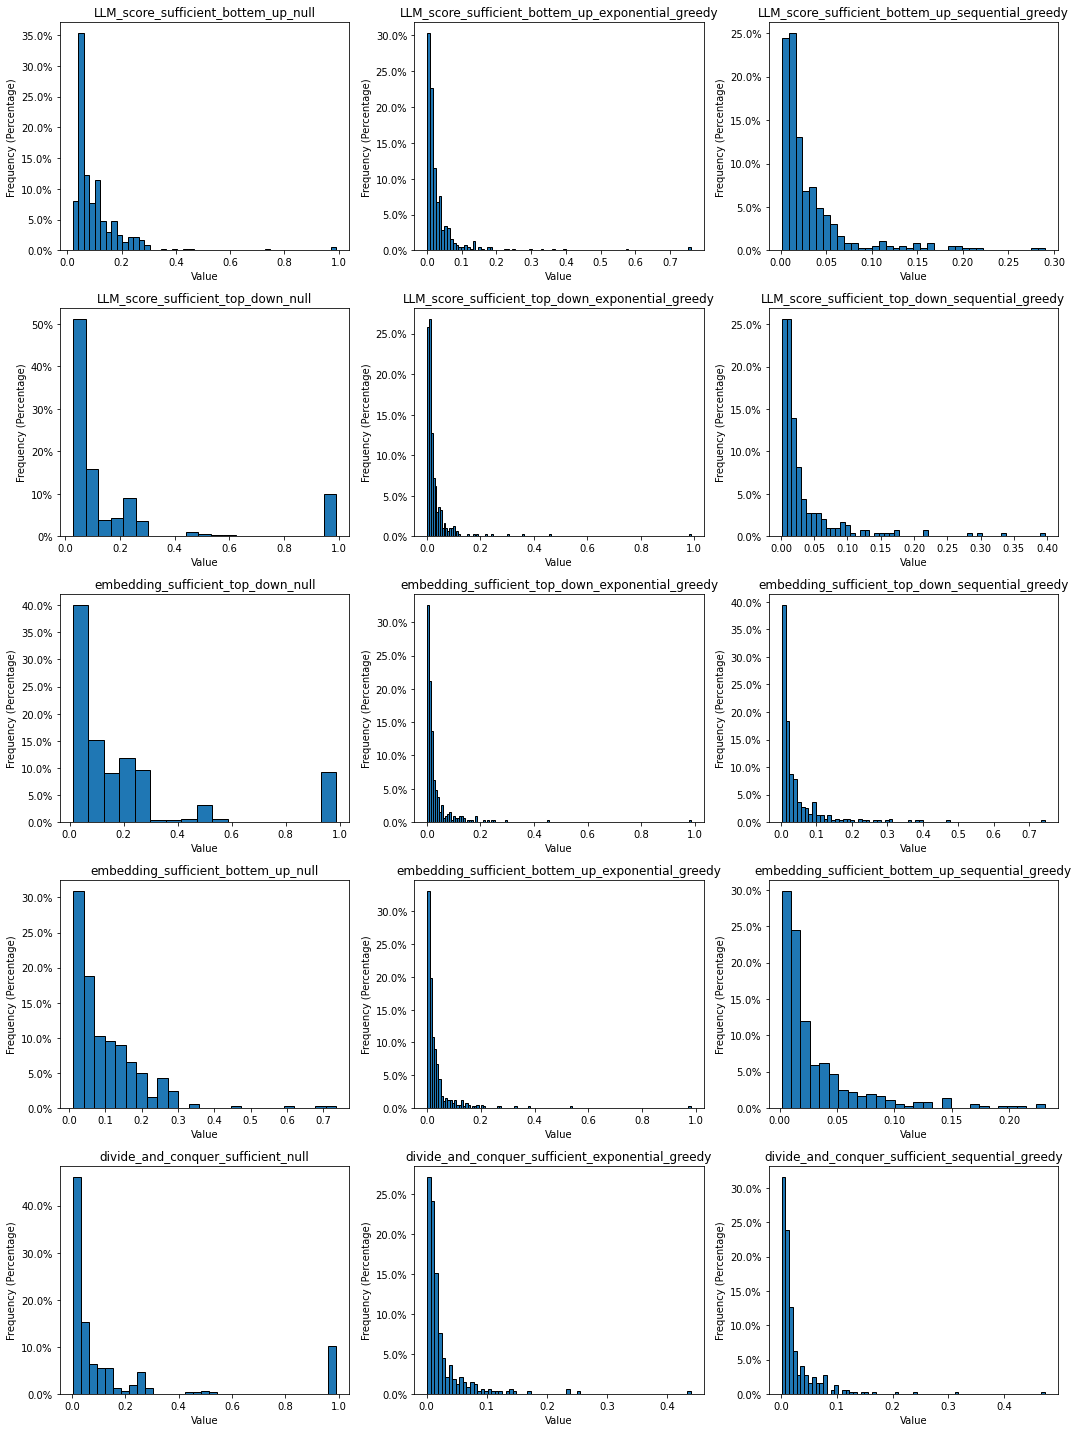

In [205]:
plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios)



LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_bottem_up_exponential_greedy
LLM_score_sufficient_bottem_up_sequential_greedy
LLM_score_sufficient_top_down_null
LLM_score_sufficient_top_down_exponential_greedy
LLM_score_sufficient_top_down_sequential_greedy
embedding_sufficient_top_down_null
embedding_sufficient_top_down_exponential_greedy
embedding_sufficient_top_down_sequential_greedy
embedding_sufficient_bottem_up_null
embedding_sufficient_bottem_up_exponential_greedy
embedding_sufficient_bottem_up_sequential_greedy
divide_and_conquer_sufficient_null
divide_and_conquer_sufficient_exponential_greedy
divide_and_conquer_sufficient_sequential_greedy


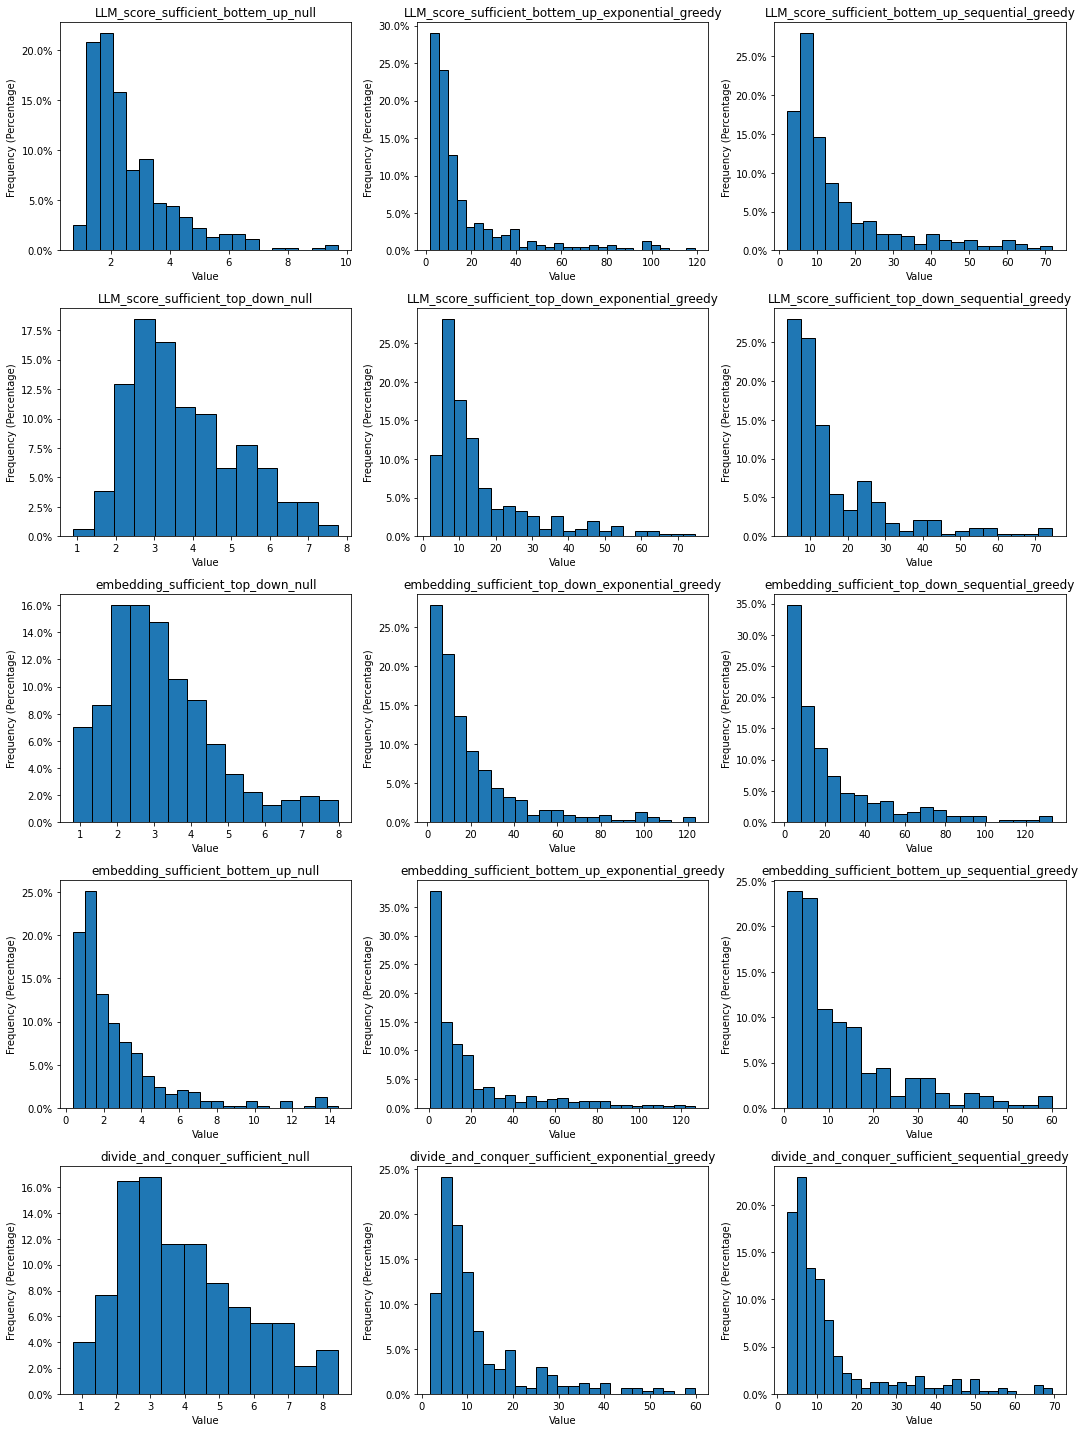

In [206]:
plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, time_distribution)

LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_bottem_up_exponential_greedy
LLM_score_sufficient_bottem_up_sequential_greedy
LLM_score_sufficient_top_down_null
LLM_score_sufficient_top_down_exponential_greedy
LLM_score_sufficient_top_down_sequential_greedy
embedding_sufficient_top_down_null
embedding_sufficient_top_down_exponential_greedy
embedding_sufficient_top_down_sequential_greedy
embedding_sufficient_bottem_up_null
embedding_sufficient_bottem_up_exponential_greedy
embedding_sufficient_bottem_up_sequential_greedy
divide_and_conquer_sufficient_null
divide_and_conquer_sufficient_exponential_greedy
divide_and_conquer_sufficient_sequential_greedy


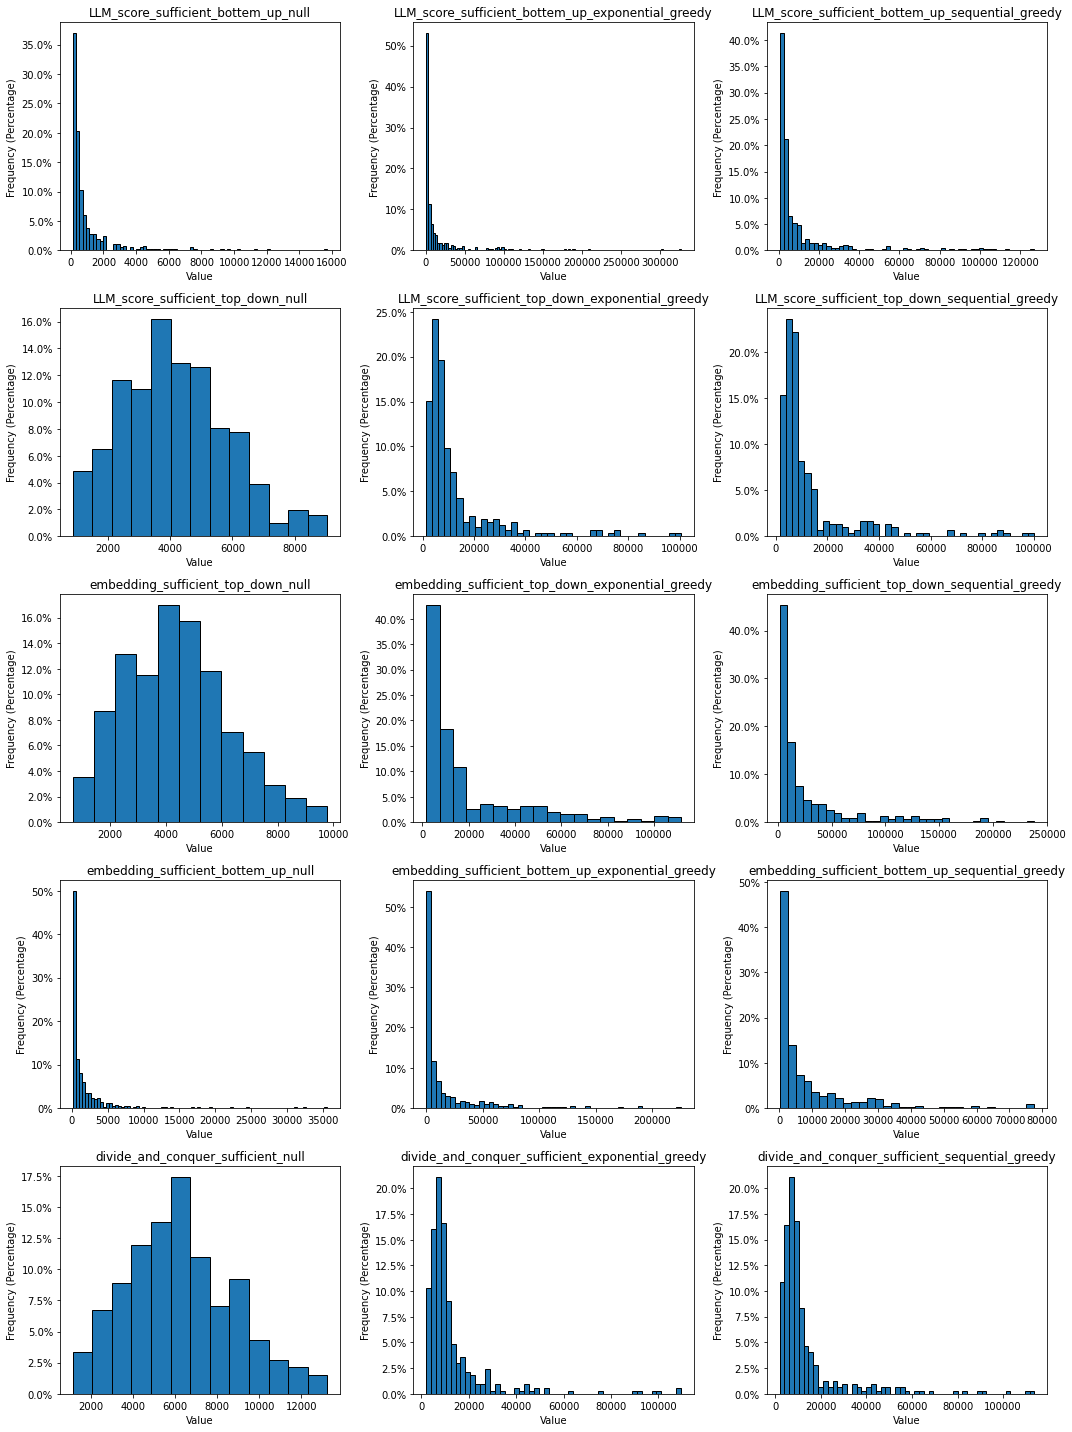

In [207]:
plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, cost_distribution)

In [216]:
#hotpot 

dataset = 'hotpotQA'
sufficient_provenance_strategy_pool = ['LLM_score_sufficient_bottem_up','LLM_score_sufficient_top_down','embedding_sufficient_top_down','embedding_sufficient_bottem_up', 'divide_and_conquer_sufficient']
minimal_provenance_strategy_pool = ['null','exponential_greedy','sequential_greedy']

data_path = parent_directory + '/data/hotpotQA_fullwiki.json'
result_folder_path = '/Users/yiminglin/Documents/Codebase/doc_provenance_results/eval' + '/hotpotQA/results_minimal/'

size_ratios, provenance_size_dict, size_ratio_dict, time_dict, cost_dict, document_size_dict, time_distribution, cost_distribution = get_aggregate_results(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, data_path, result_folder_path,dataset)

    
                

LLM_score_sufficient_bottem_up_null
provenance_size, size_ratio: 265.16083916083915 0.23090560392891496
time: 1.4153014421463013
tokens: 352.6993006993007 4.856643356643357

LLM_score_sufficient_bottem_up_exponential_greedy
provenance_size, size_ratio: 81.89626556016597 0.07285952510178059
time: 4.631294662032385
tokens: 1927.1244813278008 28.116182572614107

LLM_score_sufficient_bottem_up_sequential_greedy
provenance_size, size_ratio: 86.53526970954357 0.076962214372749
time: 4.7644908329263265
tokens: 1882.2946058091286 31.477178423236513

LLM_score_sufficient_top_down_null
provenance_size, size_ratio: 348.31481481481484 0.29476059449781594
time: 1.7444683233896892
tokens: 922.6407407407407 7.92962962962963

LLM_score_sufficient_top_down_exponential_greedy
provenance_size, size_ratio: 94.25806451612904 0.08315657205944613
time: 5.503831173143079
tokens: 3187.701612903226 36.733870967741936

LLM_score_sufficient_top_down_sequential_greedy
provenance_size, size_ratio: 101.4089068825911

1233.143196593181


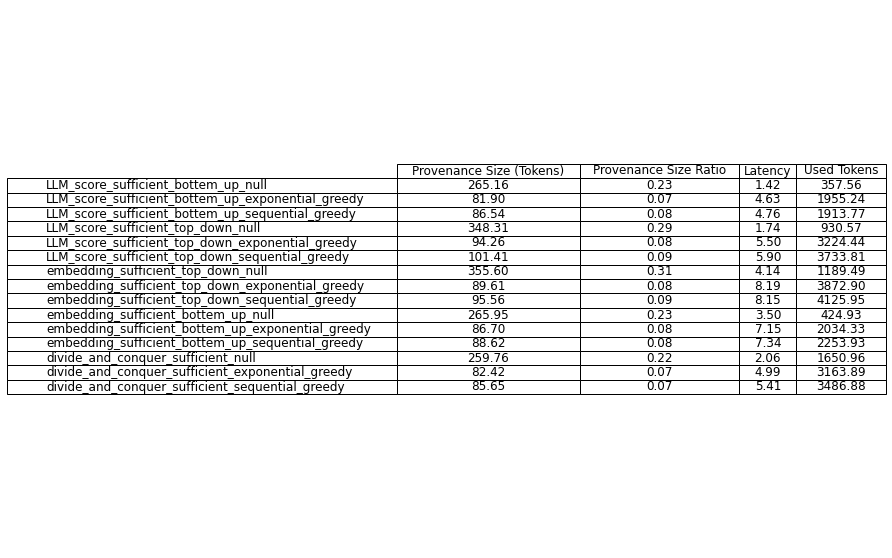

In [209]:
document_size = sum(document_size_dict.values()) / len(document_size_dict)
print(document_size)
plot_table(provenance_size_dict, size_ratio_dict, time_dict, cost_dict)

LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_bottem_up_exponential_greedy
LLM_score_sufficient_bottem_up_sequential_greedy
LLM_score_sufficient_top_down_null
LLM_score_sufficient_top_down_exponential_greedy
LLM_score_sufficient_top_down_sequential_greedy
embedding_sufficient_top_down_null
embedding_sufficient_top_down_exponential_greedy
embedding_sufficient_top_down_sequential_greedy
embedding_sufficient_bottem_up_null
embedding_sufficient_bottem_up_exponential_greedy
embedding_sufficient_bottem_up_sequential_greedy
divide_and_conquer_sufficient_null
divide_and_conquer_sufficient_exponential_greedy
divide_and_conquer_sufficient_sequential_greedy


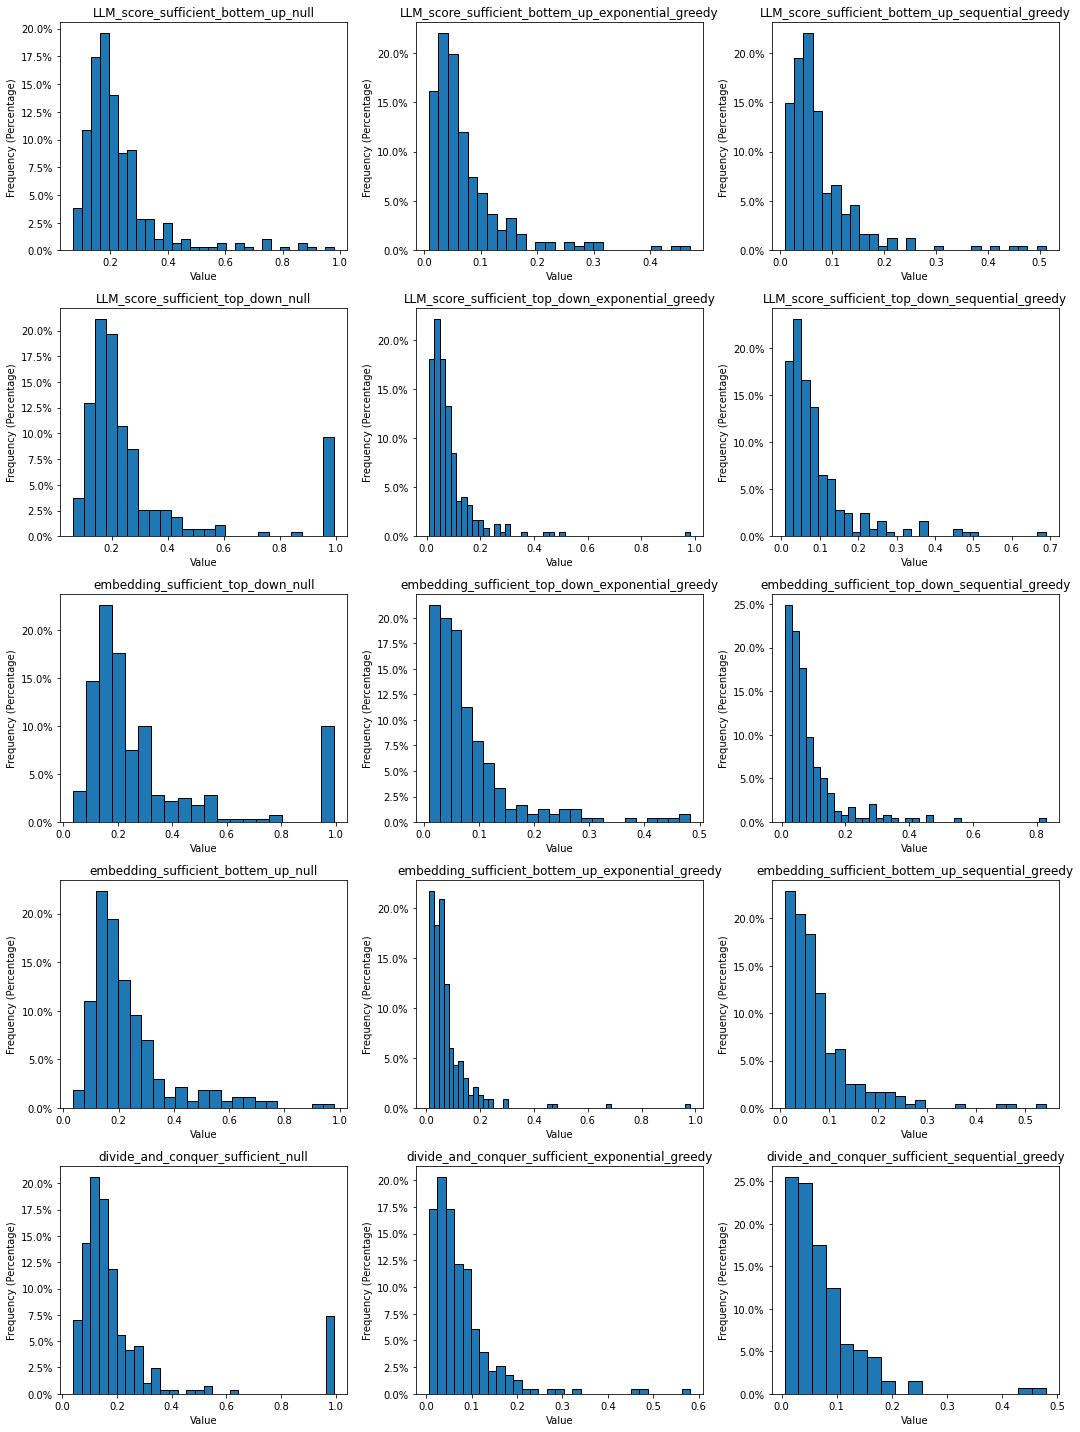

In [210]:
plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, size_ratios)



LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_bottem_up_exponential_greedy
LLM_score_sufficient_bottem_up_sequential_greedy
LLM_score_sufficient_top_down_null
LLM_score_sufficient_top_down_exponential_greedy
LLM_score_sufficient_top_down_sequential_greedy
embedding_sufficient_top_down_null
embedding_sufficient_top_down_exponential_greedy
embedding_sufficient_top_down_sequential_greedy
embedding_sufficient_bottem_up_null
embedding_sufficient_bottem_up_exponential_greedy
embedding_sufficient_bottem_up_sequential_greedy
divide_and_conquer_sufficient_null
divide_and_conquer_sufficient_exponential_greedy
divide_and_conquer_sufficient_sequential_greedy


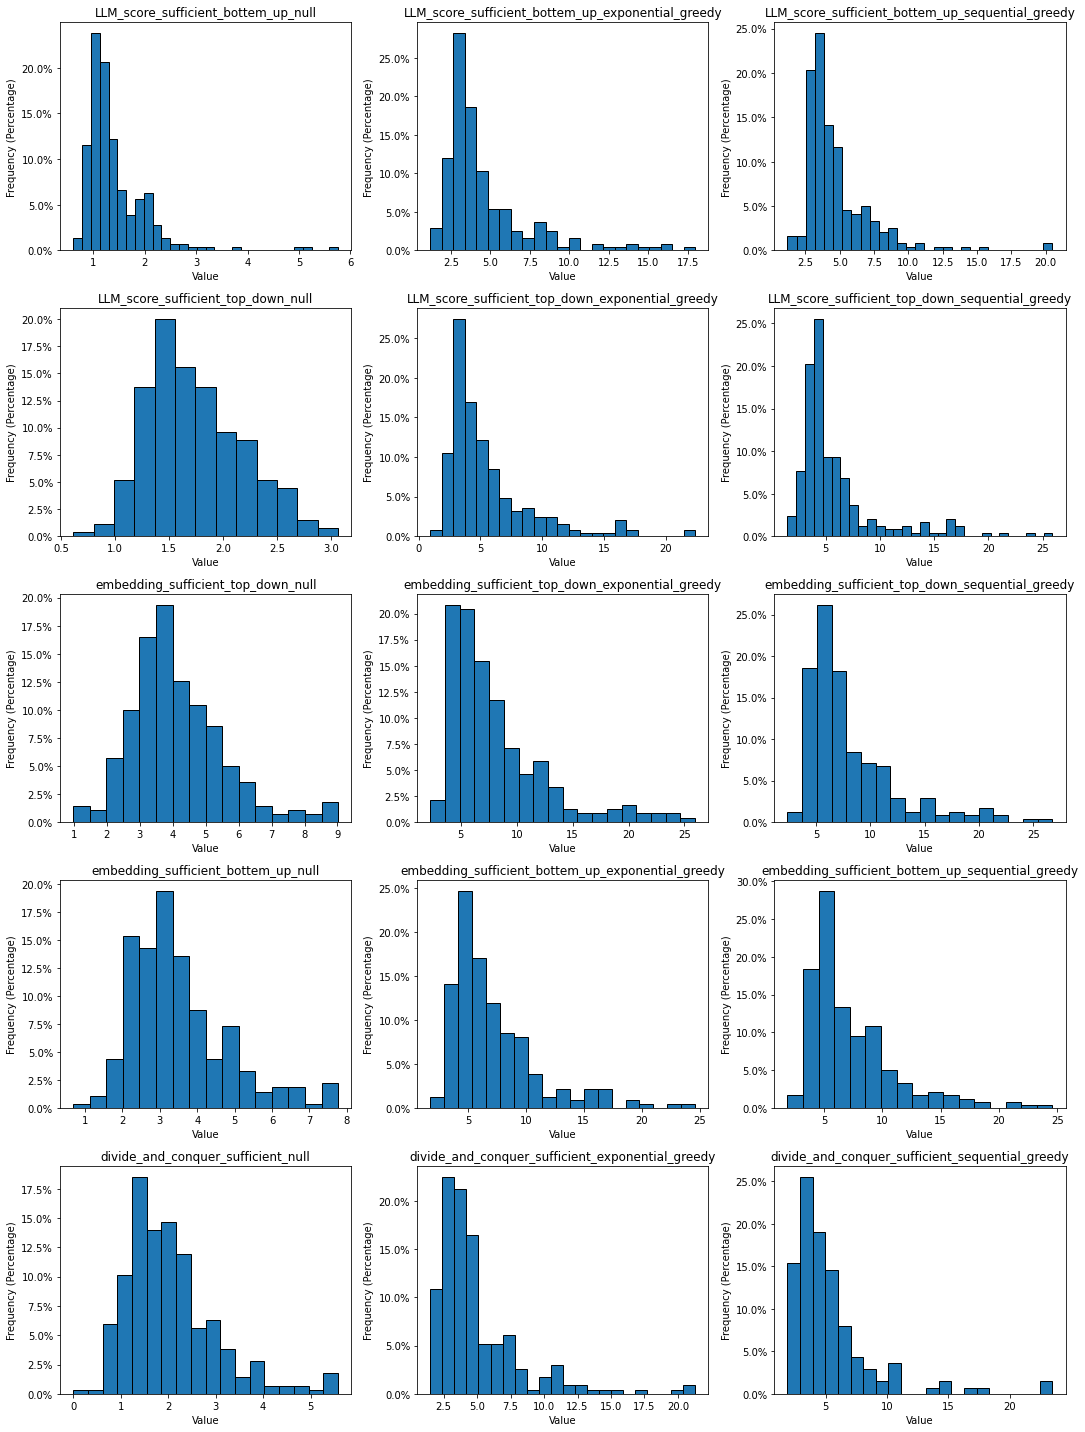

In [211]:
plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, time_distribution)

LLM_score_sufficient_bottem_up_null
LLM_score_sufficient_bottem_up_exponential_greedy
LLM_score_sufficient_bottem_up_sequential_greedy
LLM_score_sufficient_top_down_null
LLM_score_sufficient_top_down_exponential_greedy
LLM_score_sufficient_top_down_sequential_greedy
embedding_sufficient_top_down_null
embedding_sufficient_top_down_exponential_greedy
embedding_sufficient_top_down_sequential_greedy
embedding_sufficient_bottem_up_null
embedding_sufficient_bottem_up_exponential_greedy
embedding_sufficient_bottem_up_sequential_greedy
divide_and_conquer_sufficient_null
divide_and_conquer_sufficient_exponential_greedy
divide_and_conquer_sufficient_sequential_greedy


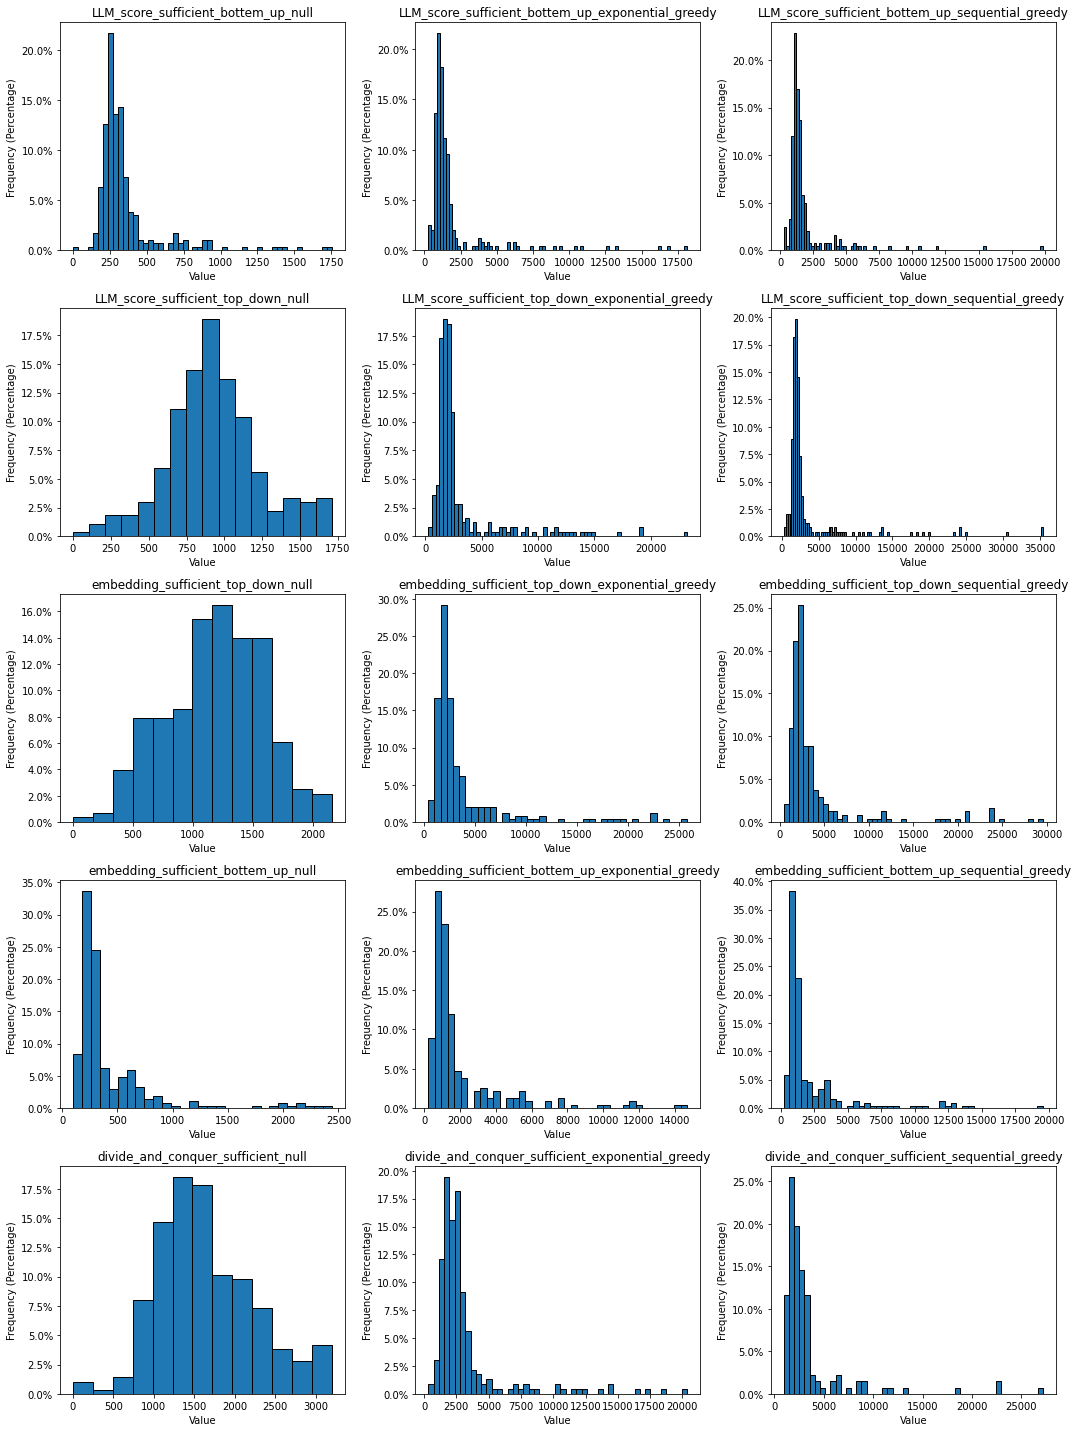

In [212]:
plot_distribution(sufficient_provenance_strategy_pool, minimal_provenance_strategy_pool, cost_distribution)